In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Utils.simulation import *
import jax 
from jax import random
jax.config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

In [2]:
N = 5000

mu = 0.473
v = 0.0166
theta = 0.1
sigma = np.sqrt(theta * (2*v) / (mu**2 + v))
mu_ln = mu_LN_from_params(mu, sigma, theta)
sigma_ln = sigma_LN_from_params(mu, sigma, sigma)

dt = 0.01#/theta
print("mu_ln: ", mu_ln)
print("sigma_ln: ", sigma_ln)

print('theta: ', theta)
print('sigma: ', sigma)
print('dt: ',dt)



T = dt*8000
n_steps = int(T/dt)
times_array = np.arange(0, n_steps) * dt
print(sigma*mu)


mu_ln:  -0.7490053697210849
sigma_ln:  0.24609939306344839
theta:  0.1
sigma:  0.11753465913798106
dt:  0.01
0.055593893772265035


In [3]:
2*theta - sigma**2

0.1861856039013186

In [4]:
def var_theoretical(mu,sigma,theta):
    num = 2*theta*mu**2*(theta-sigma**2)
    den = 2*theta**2 - 3*theta*sigma**2 + sigma**4
    return num/den - mu**2

def exact_mean(x_0, t, mu, theta, sigma):
    return x_0 * jnp.exp(-theta * t) + mu * (1 - jnp.exp(-theta * t))

def exact_second_moment(x_0, t, mu, theta, sigma):
    numerator = (
        jnp.exp(-2 * theta * t) * (
            2 * mu**2 * theta * (
                theta * jnp.exp(sigma**2 * t) +
                (theta - sigma**2) * jnp.exp(2 * theta * t) +
                (sigma**2 - 2 * theta) * jnp.exp(theta * t)
            ) +
            2 * mu * x_0 * theta * (
                2 * theta - sigma**2
            ) * (
                jnp.exp(theta * t) - jnp.exp(sigma**2 * t)
            ) +
            x_0**2 * (
                2 * theta**2 - 3 * theta * sigma**2 + sigma**4
            ) * jnp.exp(sigma**2 * t)
        )
    )

    denominator = 2 * theta**2 - 3 * theta * sigma**2 + sigma**4

    return numerator / denominator


def exact_var(x_0, t, mu, theta, sigma):
    return exact_second_moment(x_0, t, mu, theta, sigma) - exact_mean(x_0, t, mu, theta, sigma)**2


def var_theoretical(mu,sigma,theta):
    num = 2*theta*mu**2*(theta-sigma**2)
    den = 2*theta**2 - 3*theta*sigma**2 + sigma**4
    return num/den - mu**2

def lognormal_distribution(x, mu, sigma):
    return 1/(x*sigma*jnp.sqrt(2*jnp.pi)) * jnp.exp(-0.5*((jnp.log(x)-mu)/sigma)**2)

V = var_theoretical(mu,sigma,theta)
print("variance: ", V)

variance:  0.016600000000000004


In [5]:
rng = random.PRNGKey(42)
rng, key = random.split(rng)

In [6]:
W_0 = jnp.ones([N])* mu *0.1

In [7]:
W = simulate_perturbation_only(key, W_0, n_steps, mu, theta, sigma, dt)

#store the data
np.save("old_results/W_no_train.npy", W)

In [8]:
#load the data
W = np.load("old_results/W_no_train.npy")
w_mean = np.mean(W[1:], axis=1)
w_var = np.var(W[1:], axis=1)

# theoretical mean and variance
x_mean_exact = exact_mean(W_0[0], times_array,mu, theta, sigma)
x_var_exact = exact_var(W_0[0],times_array, mu, theta, sigma)


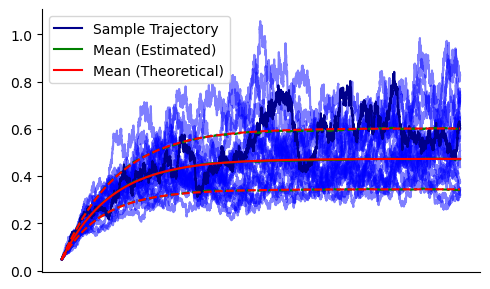

In [18]:
plt.figure(figsize=(5, 3))

plt.fontsize = 10
plt.plot(times_array,W[1:, :20] , alpha=0.5, color='blue')
plt.plot(times_array,W[1:, 4] ,  color='darkblue', label = "Sample Trajectory")
plt.plot(times_array, w_mean, color='green', label = "Mean (Estimated)")
plt.plot(times_array, w_mean + np.sqrt(w_var),  '--',color='green')
plt.plot(times_array, w_mean - np.sqrt(w_var), '--',color='green')
plt.plot(times_array, x_mean_exact, color='red', label = "Mean (Theoretical)")
plt.plot(times_array, x_mean_exact + np.sqrt(x_var_exact), '--', color='red')
plt.plot(times_array, x_mean_exact - np.sqrt(x_var_exact), '--', color='red')
#remove the top and right axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#remove x ticks
plt.xticks([])

plt.tight_layout()
plt.legend()
plt.savefig("Perturbation_only.png", transparent=True, dpi=300)
plt.show()

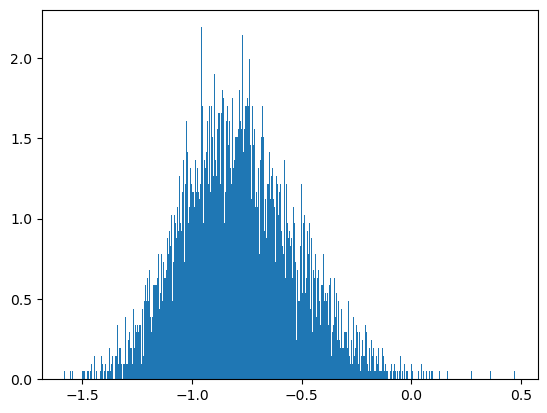

In [29]:
W_last = W[-1] 
plt.hist(np.log(W_last), bins=500, density=True)
x = np.linspace(0, 4, 1000)
mean_log = jnp.mean(jnp.log(W_last))
std_log = jnp.std(jnp.log(W_last))
# y = lognormal_distribution(x, mean_log, std_log)
# plt.plot(x, y, color='red')
plt.show()


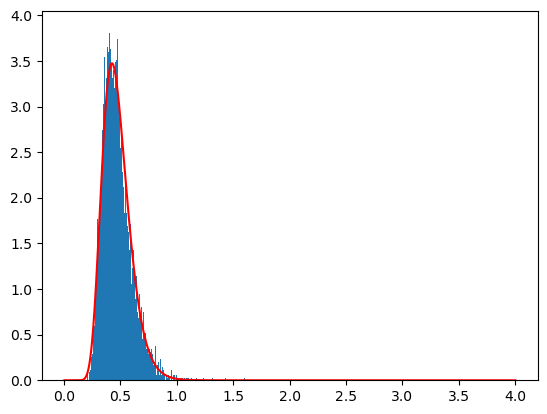

In [30]:
W_last = W[-1] 
plt.hist(W_last, bins=200, density=True)
x = np.linspace(0, 4, 1000)
mean_log = jnp.mean(jnp.log(W_last))
std_log = jnp.std(jnp.log(W_last))
y = lognormal_distribution(x, mean_log, std_log)
plt.plot(x, y, color='red')





plt.show()


#plot lognormal distribution on top


In [31]:
print("mean: ", np.mean(W_last), "variance: ", np.var(W_last))

mean:  0.4716411567156858 variance:  0.017028957896129505


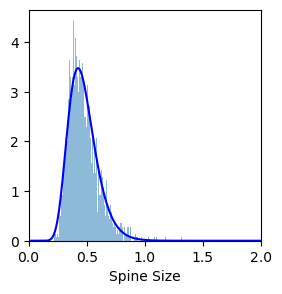

In [32]:
W_last = W[-1]
plt.figure(figsize=(3, 3))
plt.hist(W_last, bins=500, density=True, alpha = 0.5)
x = np.linspace(0, 4, 1000)

mean_log = jnp.mean(jnp.log(W_last))
std_log = jnp.std(jnp.log(W_last))
y = lognormal_distribution(x, mean_log, std_log)
#y_wrong = lognormal_distribution(x, mu_ln, np.sqrt(sigma_ln))
plt.plot(x, y, color='blue')
# plt.plot(x, y_wrong, color='green')
plt.xlabel("Spine Size")
plt.xlim(0, 2)
plt.savefig("Spine_size_distribution.png", transparent=True, dpi=300)
plt.show()

np.save("old_results/spine_size_distribution.npy", W_last)

In [33]:
import scipy

time_dist =   15
D_t_steps = int(time_dist//dt)
print(D_t_steps)
Delta = W[-1] - W[-1-D_t_steps]
Delta_2 = W[-1-D_t_steps] - W[-1-2*D_t_steps]

print("std ", np.std(Delta))


#do a linear fit and plot it
m, b = np.polyfit(Delta, Delta_2, 1)
print(m)



1499
std  0.16208084138217446
-0.4048863760905555


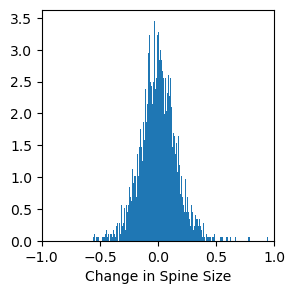

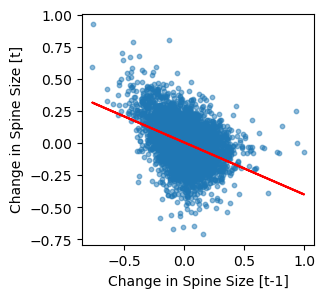

In [34]:
plt.figure(figsize=(3, 3))
plt.hist(Delta, bins=500, density=True)
plt.xlim(-1,1)
#write x axes label
plt.xlabel("Change in Spine Size")
plt.savefig("Change_in_spine_size.png", transparent=True, dpi=300)
plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(Delta, Delta_2, alpha= 0.5,  s = 10)
plt.xlabel("Change in Spine Size [t-1]")
plt.ylabel("Change in Spine Size [t]")
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.plot(Delta, m*Delta + b, 'r')
plt.savefig("Change_in_spine_size_correlation.png", transparent=True, dpi=300)
#save the figure with high resolution
# plt.savefig("Change_in_spine_size_correlation.png", transparent=True, dpi=300)
plt.show()

np.save("old_results/Change_in_spine_size_t.npy", Delta)
np.save("old_results/Change_in_spine_size_t-1.npy", Delta_2)

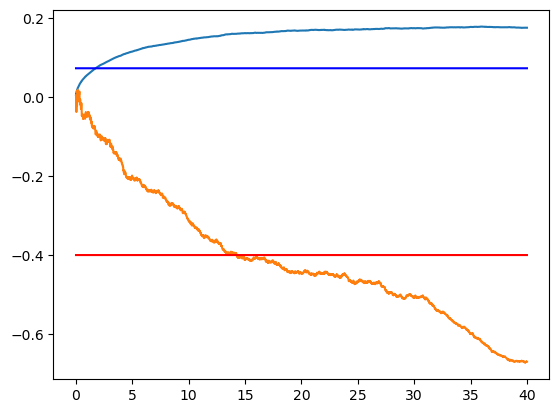

In [35]:
time_dist_list = np.arange(0 + dt, T//2, dt)
std_list = []
m_list = []
#import pearson correlation


for delta in time_dist_list:
    D_t_steps = int(delta//dt)
    Delta = W[-1] - W[-1-D_t_steps]
    std_list.append(np.std(Delta))
    Delta_2 = W[-1-D_t_steps] - W[-1-2*D_t_steps]
    #compute correlation coefficient
    C = np.corrcoef(Delta, Delta_2)
    m_list.append(C[0,1])

    
plt.plot(time_dist_list, std_list)
plt.plot(time_dist_list, m_list)
plt.plot(time_dist_list, np.ones(len(time_dist_list))*0.073, 'b')
plt.plot(time_dist_list, np.ones(len(time_dist_list))*-0.4, 'r')
plt.show()

In [36]:
C

array([[ 1.        , -0.67023271],
       [-0.67023271,  1.        ]])

In [37]:
V

0.016600000000000004